In [47]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [48]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl

# setting parameters for default matplotlib plots
%matplotlib inline

In [49]:
pl.style.use('fabiostyle')

# needs to find the library of functions
sys.path.append('../../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [50]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [51]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'selectivity_intrasession_JSB'

In [52]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [53]:
folder = './autorestore/preprocessing'
for var in ('time_ax', 'traces', 'events', 'areas', 'cycles', 'licks', 'rewards',
            'is_rewardt', 'is_CSmt', 'is_sht', 'is_rewarded', 'CYCLE_START', 'CS_DURATION', 'DELAY'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))
    
folder = './autorestore/lambo'
for var in ('reward_times', 'is_rewarded'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))

In [54]:
def update_selectivity(selectivity, trial_types, between_what, and_what, append='', append_trial='t'):

    for t in trial_types:

        # this one selects which trials to consider
        which_cycles = eval('is_%s'%(t+append_trial))
#         print sum(which_cycles)

        if not np.any(which_cycles):
            continue
        
        selectivity[t+append] = ut.compute_selectivity(time_ax, events, cycles[which_cycles],
                                                       between_what, and_what)

In [55]:
cs_timeframe = (-CYCLE_START, CS_DURATION-CYCLE_START)
tr_timeframe = (-CYCLE_START+CS_DURATION, -CYCLE_START+CS_DURATION+DELAY)
cs_tr_timeframe = (-CYCLE_START, CS_DURATION-CYCLE_START+DELAY)
us_timeframe = (CS_DURATION-CYCLE_START+DELAY, CS_DURATION-CYCLE_START+DELAY+2)
prebaseline_timeframe = (-CYCLE_START-4, -CYCLE_START-2)
baseline_timeframe = (-CYCLE_START-2, -CYCLE_START)
baseline_cstr_timeframe = (-CYCLE_START-4, -CYCLE_START)
selectivity = {}

update_selectivity(selectivity, ['CSmt', 'rewardt', 'sht'], cs_timeframe, baseline_timeframe, '', append_trial='')
update_selectivity(selectivity, ['CSmt', 'rewardt', 'sht'], tr_timeframe, baseline_timeframe, '_tr', append_trial='')
update_selectivity(selectivity, ['CSmt', 'rewardt', 'sht'], cs_tr_timeframe, baseline_cstr_timeframe, '_cstr', append_trial='')
update_selectivity(selectivity, ['CSmt', 'rewardt', 'sht'], us_timeframe, baseline_timeframe, '_us', append_trial='')
update_selectivity(selectivity, ['CSmt', 'rewardt', 'sht'], prebaseline_timeframe, baseline_timeframe, '_prebs', append_trial='')

times = reward_times[is_rewarded]
us_timeframe_licks = np.c_[us_timeframe[0]+times, us_timeframe[0]+times+2]
selectivity['rewardt_licks'] = ut.compute_selectivity(time_ax, events, cycles[is_rewardt][is_rewarded],
                                               us_timeframe_licks, baseline_timeframe)

In [56]:
selectivity.keys()

['CSmt_prebs',
 'sht',
 'rewardt',
 'rewardt_licks',
 'sht_tr',
 'CSmt_cstr',
 'CSmt_tr',
 'rewardt_cstr',
 'sht_cstr',
 'sht_us',
 'rewardt_prebs',
 'CSmt',
 'rewardt_tr',
 'rewardt_us',
 'CSmt_us',
 'sht_prebs']

In [57]:
significance = 0.05

for t in np.sort(selectivity.keys()):
    print t, np.mean([s[1]<significance for s in selectivity[t][:, 0]])

CSmt 0.1875
CSmt_cstr 0.3125
CSmt_prebs 0.104166666667
CSmt_tr 0.25
CSmt_us 0.208333333333
rewardt 0.166666666667
rewardt_cstr 0.416666666667
rewardt_licks 0.1875
rewardt_prebs 0.0625
rewardt_tr 0.208333333333
rewardt_us 0.208333333333
sht 0.229166666667
sht_cstr 0.270833333333
sht_prebs 0.166666666667
sht_tr 0.1875
sht_us 0.208333333333


In [58]:
significance = 0.05

for t in np.sort(selectivity.keys()):
    print t, np.mean(ut.adjust_pvalues([s[1] for s in selectivity[t][:, 0]])<significance)

CSmt 0.0
CSmt_cstr 0.125
CSmt_prebs 0.0
CSmt_tr 0.125
CSmt_us 0.104166666667
rewardt 0.0625
rewardt_cstr 0.1875
rewardt_licks 0.0625
rewardt_prebs 0.0208333333333
rewardt_tr 0.0625
rewardt_us 0.104166666667
sht 0.0208333333333
sht_cstr 0.0
sht_prebs 0.0208333333333
sht_tr 0.0208333333333
sht_us 0.1875


(0, 100)

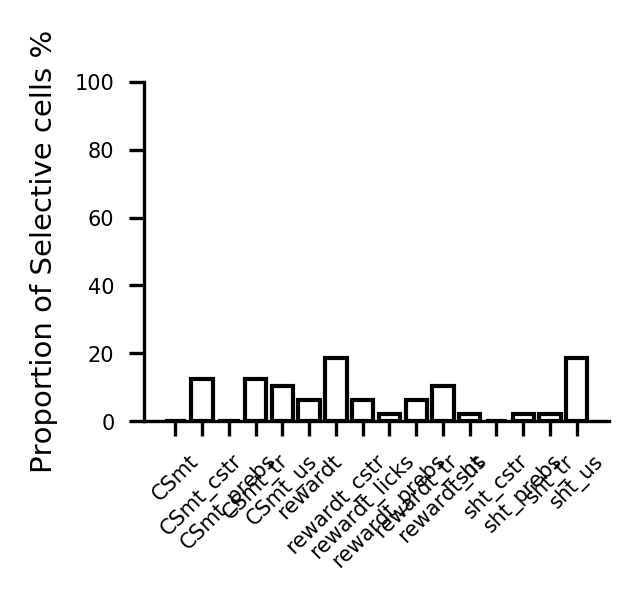

In [59]:
significance = 0.05

fig, ax = pl.subplots(1, 1, figsize=(2, 1.5))
values = [np.mean(ut.adjust_pvalues([s[1] for s in selectivity[t][:, 0]])<significance)*100
          for t in np.sort(selectivity.keys())]
pt.plot_bars(values, ax=ax)
ax.set_xticks(range(len(selectivity)))
ax.set_xticklabels(np.sort(selectivity.keys()), rotation=45)
pt.nicer_plot(ax)
ax.set_ylabel('Proportion of Selective cells %')
ax.set_ylim(0, 100)

# Breaking up session

In [60]:
#fuction slices session into equally sized divisions (as is defined by 'session split') for each trial type

def update_intrasession_selectivity(intrasession_selectivity, trial_types, between_what, and_what, append='', append_trial='t'):

    slicing_index=[]
    for t in trial_types:
        which_cycles = eval('is_%s'%(t+append_trial))
        del slicing_index[:]
        slicing_index=[0]
        for s in session_split_list:
            n_trials = sum(which_cycles)/session_split  # how many trials must session be split into?
            first_trial = (n_trials*s)-(n_trials)  # where do we begin extracting trials from for this interation
            slicing_trial = n_trials*s  #where do we stop extracting trials from for this iteration              
    
            if not np.any(which_cycles):
                continue
            
            intrasession_selectivity[t+append+'_'+str(s)+'of'+str(session_split)] = ut.compute_selectivity(time_ax, events, cycles[which_cycles][first_trial:slicing_trial],
                                                           between_what, and_what)

In [61]:
session_split = 3  #how many divisions do we wish to split session into? Should define this in preprocessing and import so it's consistent across animals&sessions
session_split_list = range(session_split+1)[1:]  #just making a list to iterate through for update fxn called below

intrasession_selectivity = {}

update_intrasession_selectivity(intrasession_selectivity, ['CSmt', 'rewardt', 'sht'], cs_timeframe, baseline_timeframe, '', append_trial='')
update_intrasession_selectivity(intrasession_selectivity, ['CSmt', 'rewardt', 'sht'], tr_timeframe, baseline_timeframe, '_tr', append_trial='')
update_intrasession_selectivity(intrasession_selectivity, ['CSmt', 'rewardt', 'sht'], cs_tr_timeframe, baseline_cstr_timeframe, '_cstr', append_trial='')
update_intrasession_selectivity(intrasession_selectivity, ['CSmt', 'rewardt', 'sht'], us_timeframe, baseline_timeframe, '_us', append_trial='')
update_intrasession_selectivity(intrasession_selectivity, ['CSmt', 'rewardt', 'sht'], prebaseline_timeframe, baseline_timeframe, '_prebs', append_trial='')

#times = reward_times[is_rewarded]
#us_timeframe_licks = np.c_[us_timeframe[0]+times, us_timeframe[0]+times+2]
#selectivity['rewardt_licks'] = ut.compute_selectivity(time_ax, events, cycles[is_rewardt][is_rewarded],
#                                               us_timeframe_licks, baseline_timeframe)

In [62]:
intrasession_selectivity.keys()

['sht_3of3',
 'CSmt_cstr_3of3',
 'CSmt_2of3',
 'rewardt_cstr_1of3',
 'CSmt_prebs_2of3',
 'CSmt_us_2of3',
 'sht_prebs_1of3',
 'rewardt_us_2of3',
 'CSmt_tr_1of3',
 'sht_prebs_2of3',
 'CSmt_tr_3of3',
 'CSmt_cstr_1of3',
 'sht_2of3',
 'sht_us_2of3',
 'rewardt_tr_1of3',
 'rewardt_prebs_1of3',
 'sht_cstr_3of3',
 'rewardt_prebs_3of3',
 'CSmt_prebs_1of3',
 'sht_tr_2of3',
 'CSmt_us_1of3',
 'CSmt_prebs_3of3',
 'rewardt_us_3of3',
 'CSmt_1of3',
 'sht_cstr_1of3',
 'CSmt_cstr_2of3',
 'sht_prebs_3of3',
 'CSmt_3of3',
 'rewardt_cstr_2of3',
 'rewardt_3of3',
 'rewardt_prebs_2of3',
 'rewardt_tr_2of3',
 'sht_tr_3of3',
 'CSmt_us_3of3',
 'sht_tr_1of3',
 'sht_1of3',
 'rewardt_cstr_3of3',
 'sht_us_1of3',
 'CSmt_tr_2of3',
 'rewardt_2of3',
 'rewardt_us_1of3',
 'sht_us_3of3',
 'rewardt_1of3',
 'rewardt_tr_3of3',
 'sht_cstr_2of3']

In [63]:
significance = 0.05

for t in np.sort(intrasession_selectivity.keys()):
    print t, np.mean([s[1]<significance for s in intrasession_selectivity[t][:, 0]])

CSmt_1of3 0.166666666667
CSmt_2of3 0.0208333333333
CSmt_3of3 0.0833333333333
CSmt_cstr_1of3 0.291666666667
CSmt_cstr_2of3 0.125
CSmt_cstr_3of3 0.0625
CSmt_prebs_1of3 0.0833333333333
CSmt_prebs_2of3 0.0416666666667
CSmt_prebs_3of3 0.0625
CSmt_tr_1of3 0.229166666667
CSmt_tr_2of3 0.0416666666667
CSmt_tr_3of3 0.0833333333333
CSmt_us_1of3 0.25
CSmt_us_2of3 0.125
CSmt_us_3of3 0.104166666667
rewardt_1of3 0.125
rewardt_2of3 0.145833333333
rewardt_3of3 0.0833333333333
rewardt_cstr_1of3 0.333333333333
rewardt_cstr_2of3 0.208333333333
rewardt_cstr_3of3 0.1875
rewardt_prebs_1of3 0.104166666667
rewardt_prebs_2of3 0.0625
rewardt_prebs_3of3 0.0208333333333
rewardt_tr_1of3 0.0833333333333
rewardt_tr_2of3 0.145833333333
rewardt_tr_3of3 0.0833333333333
rewardt_us_1of3 0.125
rewardt_us_2of3 0.0833333333333
rewardt_us_3of3 0.125
sht_1of3 0.208333333333
sht_2of3 0.104166666667
sht_3of3 0.0208333333333
sht_cstr_1of3 0.333333333333
sht_cstr_2of3 0.229166666667
sht_cstr_3of3 0.104166666667
sht_prebs_1of3 0.06

In [64]:
significance = 0.05

for t in np.sort(intrasession_selectivity.keys()):
    print t, np.mean(ut.adjust_pvalues([s[1] for s in intrasession_selectivity[t][:, 0]])<significance)

CSmt_1of3 0.0
CSmt_2of3 0.0
CSmt_3of3 0.0
CSmt_cstr_1of3 0.145833333333
CSmt_cstr_2of3 0.0
CSmt_cstr_3of3 0.0
CSmt_prebs_1of3 0.0
CSmt_prebs_2of3 0.0
CSmt_prebs_3of3 0.0
CSmt_tr_1of3 0.0
CSmt_tr_2of3 0.0
CSmt_tr_3of3 0.0
CSmt_us_1of3 0.0
CSmt_us_2of3 0.0
CSmt_us_3of3 0.0
rewardt_1of3 0.0
rewardt_2of3 0.0
rewardt_3of3 0.0416666666667
rewardt_cstr_1of3 0.0625
rewardt_cstr_2of3 0.0
rewardt_cstr_3of3 0.0208333333333
rewardt_prebs_1of3 0.0
rewardt_prebs_2of3 0.0
rewardt_prebs_3of3 0.0
rewardt_tr_1of3 0.0208333333333
rewardt_tr_2of3 0.0
rewardt_tr_3of3 0.0208333333333
rewardt_us_1of3 0.0416666666667
rewardt_us_2of3 0.0208333333333
rewardt_us_3of3 0.0
sht_1of3 0.0
sht_2of3 0.0
sht_3of3 0.0
sht_cstr_1of3 0.0208333333333
sht_cstr_2of3 0.0
sht_cstr_3of3 0.0
sht_prebs_1of3 0.0
sht_prebs_2of3 0.0
sht_prebs_3of3 0.0208333333333
sht_tr_1of3 0.0
sht_tr_2of3 0.0
sht_tr_3of3 0.0
sht_us_1of3 0.0208333333333
sht_us_2of3 0.0416666666667
sht_us_3of3 0.0208333333333


(0, 100)

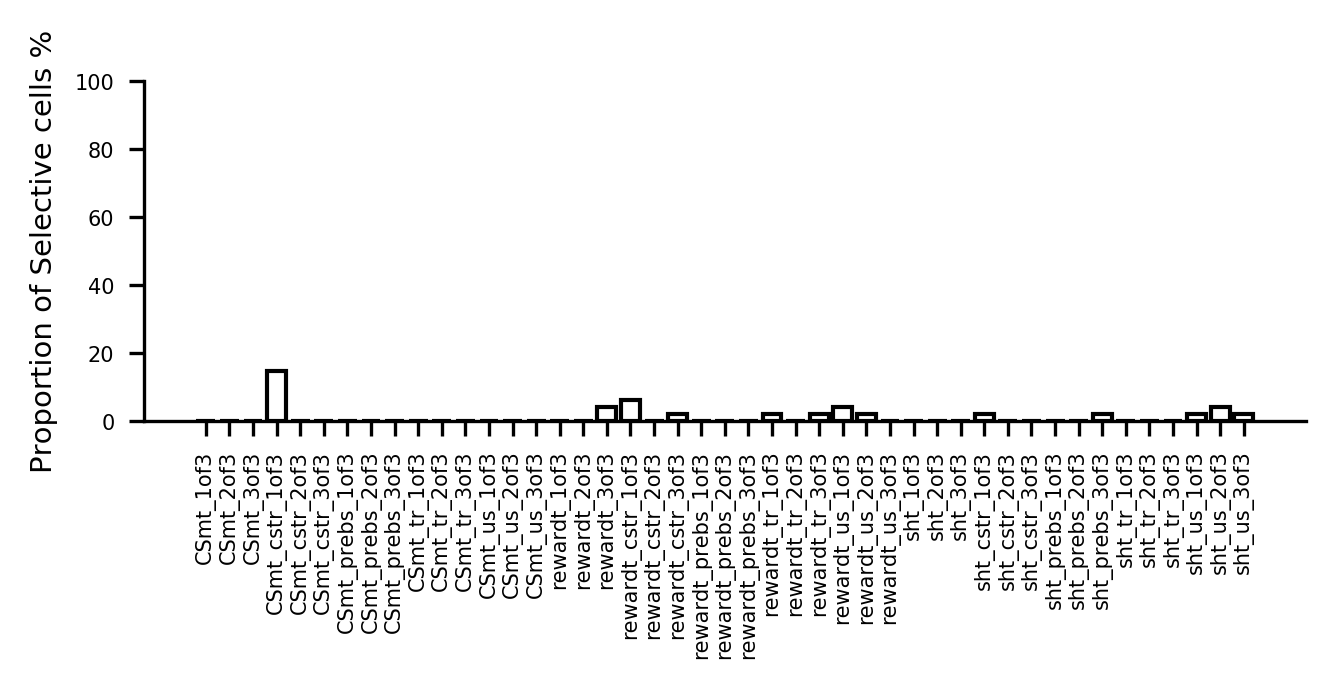

In [65]:
significance = 0.05

fig, ax = pl.subplots(1, 1, figsize=(5, 1.5))
values = [np.mean(ut.adjust_pvalues([s[1] for s in intrasession_selectivity[t][:, 0]])<significance)*100
          for t in np.sort(intrasession_selectivity.keys())]
pt.plot_bars(values, ax=ax)
ax.set_xticks(range(len(intrasession_selectivity)))
ax.set_xticklabels(np.sort(intrasession_selectivity.keys()), rotation=90)
pt.nicer_plot(ax)
ax.set_ylabel('Proportion of Selective cells %')
ax.set_ylim(0, 100)

In [66]:
for o in ['CSmt', 'rewardt', 'sht']:
    exec("cells_%s = ut.adjust_pvalues([s[1] for s in selectivity[\'%s\'][:, 0]])<significance"%(o, o))
cells_CSmt_rwt = cells_CSmt*cells_rewardt
cells_sht_rwt = cells_sht*cells_rewardt
cells_CSmt_sht = cells_CSmt*cells_sht

In [67]:
tuned_CSmt = np.argwhere(cells_CSmt).flatten()
tuned_rewardt = np.argwhere(cells_rewardt).flatten()
tuned_sht = np.argwhere(cells_sht).flatten()

In [68]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...


# Obsolete code

In [69]:
# def findsum(a, n):
#     for i in range(len(a)+1):
#         if sum(a[:i]) == n:
#             firstsum.append(1)
#         else:
#             firstsum.append(0)
#     return firstsum

# firstsum=[]

In [70]:
# #fuction will slice session into equally sized divisions (as is defined by 'session split') within each trial type. ie, if we want to 
#     #break up a 120-trial session into halves, it will find the first 60 trials of rewardt and CSmt, and latter 60 of each. It will NOT
#     #break up session simply by half the total number of trials (which could lead to an uneven # of trial types due to pseudorandom nature
#     #of trial selection by Arduino)

# def update_intrasession_selectivity(intrasession_selectivity, trial_types, between_what, and_what, append='', append_trial='t'):

#     slicing_index=[]
#     for t in trial_types:
#         which_cycles = eval('is_%s'%(t+append_trial))
#         del slicing_index[:]
#         slicing_index=[0]
#         for s in session_split_list:
#             n_trials = sum(which_cycles)/session_split  # how many trials must session be split into?
#             print n_trials
#             first_trial = (n_trials*s)-(n_trials)  # where do we begin extracting trials from for this interation
#             slicing_trial = n_trials*s  #where do we stop extracting trials from for this iteration
#             print first_trial
#             print slicing_trial
         # AAArgh, the below is all moot. But basically it finds, out of a collection of trials, how many total trials are needed
         # to capture a defined number of subtrials (eg, how many cycles have transpired when the 30th CSmt trial occurs)
#             firstsum=[]  #initializing list 
#             firstsum = findsum(which_cycles,slicing_trial) #function used for finding the index of where we should stop extracting values
#             print firstsum
#             slicing_index.append(firstsum.index(1))   # find first instance where slicing trial value is present in which_cycles
#             print slicing_index
#             del firstsum[:]   # delete the contents of list so we can start over on next iteration
#             if slicing_index[s-1]==0:  #will use to define how which_cycles should be sliced
#                 which_trials = range(slicing_index[s-1],slicing_index[s]+1)
#             else:
#                 which_trials = range(slicing_index[s-1]+1,slicing_index[s]+1)
#             print which_trials
#             print (which_trials[0]),(which_trials[-1])
#             print 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
#             print cycles[which_cycles][61:119]
#             print which_cycles
                
    
#             if not np.any(which_cycles):
#                 continue
            
#             intrasession_selectivity[t+append+'_'+str(s)+'of'+str(session_split)] = ut.compute_intrasession_selectivity(time_ax, events, cycles[which_cycles][(which_trials[0]):(which_trials[-1])],
#                                                            between_what, and_what)
#     return intrasession_selectivity[t+append+'_'+str(s)+'of'+str(session_split)]